# Using MONAI to unlock clinically valuable insights from Digital Pathology

## Part 2 - Nuclei segmentation and classification with MONAI

![image](images/monai.png)

In the first section, you saw how we can speed up the loading and decoding of large images by using a high-performance image loader such as cuCIM. You also saw how we can use multi-threading to reduce the latency of loading a large image. So long as the image format and loader supports loading regions of interest then we can use different processes or threads to simultaneously get different parts of the image into memory. 

Often, the image loading can be the bottleneck that slows the whole processing pipeline down. Of course it is often not just the loading that we need to do. There may be a need to do some preprocessing on the image and, for digital pathology, we may need to threshold each region to ensure that we are not wasting time processing empty or background regions of the Whole Slide. There may also be some image transformation or augmentation to do. All of these operations can become the part that slows everything else down and results in under-utilised GPUs, if not dealt with efficiently.

We are going to work through an example in which we use the HoVerNet network and post-processing pipeline to detect, localise and classify nuclei and then, in the following notebook, analyse the output.

![image](images/hovernet2.png)

We start off by importing the libraries we need Python to be able to use

In [177]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import sys

# General Python libraries
from functools import partial
from matplotlib import pyplot as plt
import logging
import os
import time
from argparse import ArgumentParser
from tqdm.auto import tqdm
import json
#import zarr

# torch-related classes
import torch
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
import numpy as np
import pandas as pd
import torch.distributed as dist

# Monai classes
from monai.config import print_config
from monai.data import DataLoader, MaskedPatchWSIDataset, decollate_batch, PatchWSIDataset
from monai.networks.nets import HoVerNet
from monai.engines import IterationEvents, SupervisedEvaluator
from monai.inferers import SimpleInferer

# Pathology-specific transforms
from monai.apps.pathology.transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
    HoVerNetInstanceMapPostProcessingd, 
    HoVerNetNuclearTypePostProcessingd,
)

from monai.apps.pathology.transforms.post.dictionary import HoVerNetNuclearTypePostProcessingd, Watershedd
from monai.apps.pathology.inferers import SlidingWindowHoVerNetInferer

# Generic Transforms
from monai.transforms import (
    Activations,
    AsChannelFirst,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    LoadImage,
    LoadImaged,
    SplitDimd,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    CenterSpatialCropd,
    FillHoles,
    BoundingRect,
    ThresholdIntensity,
    NormalizeIntensityd,
    GaussianSmooth,
    apply_transform,
)

# Event handlers
from monai.handlers import (
    EarlyStopHandler,
    MeanDice,
    StatsHandler,
    TensorBoardStatsHandler,
    from_engine,
    DecollateBatch,
)
from monai.utils import convert_to_tensor, first, HoVerNetBranch

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/envs/rapids/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest

The output of print_config provides us with a useful summary of the installed monai components and dependencies. If you encounter any issues when developing with Monai, it can be useful to include this output in any issues you raise in the GitHub repo

As before, we we will be working with the same image from the TCGA archive. However, rather than loading the image directly, we are going to look at how Monai abstracts the loading of images away. There are many different possibilities for loading data in Monai because it is a very flexible API. 
Sometimes, it makes sense to just point a Monai engine at a data source, such as a folder of images and let it run automatically, using a pre-configured pipeline. at other times you may have different requirements that necessitate some customisation at some level. We will take a look at a few of these options.

First off, let's look at some of the Monai components that comprise a typical pipeline. 
We need to define a source of some images. We formulate this as a list of dictionaries to fit with the way that Monai operates.

In [1]:
data_list = [
    {"image": "/datasets/dli_gtc_23/data/images/im_test1.nii.gz"},
    {"image": "/datasets/dli_gtc_23/data/images/im_test2.nii.gz"},
    {"image": "/datasets/dli_gtc_23/data/images/im_test3.nii.gz"},
    {"image": "/datasets/dli_gtc_23/data/images/im_test4.nii.gz"},
    {"image": "/datasets/dli_gtc_23/data/images/im_test5.nii.gz"},
    {"image": "/datasets/dli_gtc_23/data/images/im_test6.nii.gz"},
]

So, we now have a list containing 6 dictionaries, each containing an "image" key and a filename as the value. We can use a Monai Transform to turn this list of images into a list of actual images. The Transform that we need to do this is LoadImaged. We could also have simply used LoadImage, which expects a List of Images rather than a List of Dictionaries, but the list of dictionaries offers more flexibility, such as allowing us to filter the items in the dictionary using their keys.
It is common to combine Transforms into a pipeline and the Compose function allows us to do that. In this initial case, there is only one item in the Compose pipeline but we could easily chain more together.

In [17]:
trans = Compose([LoadImage(image_only=True)])
img = trans(data_list[0]["image"])
print(type(img), img.shape, img.get_device())

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 2000, 2000]) -1


/opt/conda/envs/rapids/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


So, we have a 2k by 2k image with 3 channels. Let's plot that out next

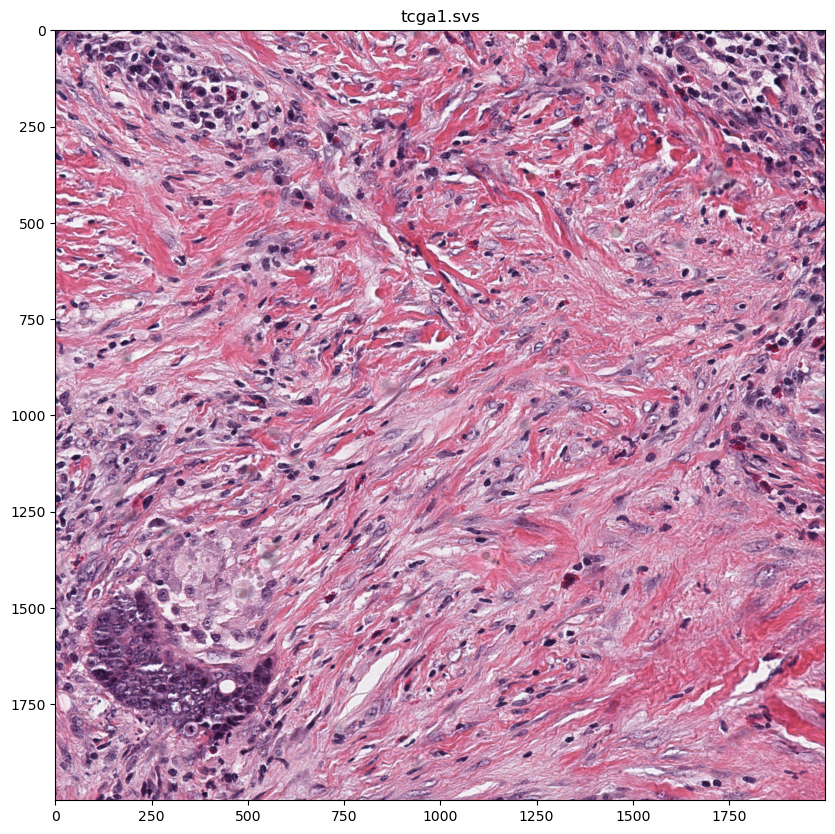

In [14]:
import matplotlib.pyplot as plt

# Use Matplotlib to display the thumbnail view of the image
plt.figure(figsize=(5,5))
plt.imshow(np.array(img).astype(int))
plt.title('tcga1.svs')
plt.show()

So, one thing that needs to be accounted for is the channel ordering. Monai, like PyTorch, on which is is based, generally uses the convention of channels being the first dimension of an image. To make sure that this is the case we can use another transform - EnsureChannelFirst. For the case in which an image has only a single channel, there may not be a separate dimension (e.g. shape = [100, 100] rather than [1, 100, 100]) but this method will create one. Otherwise it will reorder the dimensions. 

In [18]:
trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(channel_dim=-1)])
img = trans(data_list[0]["image"])
print(type(img), img.shape, img.get_device())

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 2000, 2000]) -1


So, this has now provided the tensor in the correct format. Note that matplotlib uses the channel-last convention, so if you want to plot the image, you will need to reorder the channels again before displaying. The other thing to note is that the type of the tensor is reported as a Monai MetaTensor. You can find out more about this type in the Monai Documentation (https://docs.monai.io/en/stable/data.html#metatensor) but it is a useful feature of Monai that allows you to examine and add to the data associated with an image tensor. For example the name of source image file or its dimensions or, in the case of Whole Slide Image processing, perhaps the coordinates of the current tile within the WSI.

To make this useful, we would most likely want to integrate a Transform into a data loading workflow. So far we used Array Tranforms, which operate on simple arrays of inputs. Now we will switch to Dictionary Tranforms, which are able to use the keys to filter the inputs. This can be useful, especially when training, because the filters can be used to deal with labels and input data separately. We are only doing inference in this case so we don't have labels but it can still be useful.

Firstly, we will redefine the Transforms to use the Dictionary equivalent functions. They always include a 'd' suffix e.g. LoadImage becomes LoadImaged. This is also a feature of PyTorch, which also has the concept of Tranforms, which can be used with Monai Transforms.

In [25]:
trans = Compose([LoadImaged(keys="image"), EnsureChannelFirstd(keys="image", channel_dim=-1)])

This has defined the Transform. Next we need to use this Transform in some sort of data flow. We will use a Monai Dataset to do this.

In [26]:
# Create an iterable from the image list
data_iterator = iter(data_list)

# Create a dataset with the data_iterator and the transforms that we defined
dataset = IterableDataset(data=data_iterator, transform=trans)

Now we can create a DataLoader to create some batches. This should yield 2 batch of 3 images, each of dimension (3, 2000, 2000)

In [31]:
dataloader = DataLoader(dataset=dataset, batch_size=3, num_workers=2)
for d in dataloader:
    print(d["image"].shape)

torch.Size([3, 3, 2000, 2000])
torch.Size([3, 3, 2000, 2000])


If we wanted to create a Dataset rather than an IterableDataset then, rather than using the iter() function, we'd need to wrap the data_list in a class that provides the necessary methods e.g.:

    class MyIterator:
        def __init__(self, data):
            self.data = data

        def __iter__(self):
            return iter(self.data)

        def __getitem__(self, index):
            return self.data[index]
This would allow us to do something like:

    data_iterator = MyIterator(data_list)
    
    dataset = Dataset(data=data_iterator, transform=trans)
    for _ in dataset:
        pass


We can also add other Tranforms, if needed. See if you can add a Transform to Normalize the Intensity of the image (use the [documentation](https://docs.monai.io/en/stable/transforms.html#intensity) to find the right Tranform) ([solution](solutions/nomalize.py))

2023-02-17 12:33:48,686 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


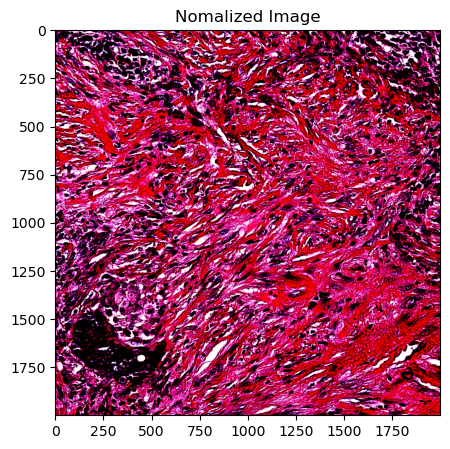

In [40]:
# TODO Add a new transform to the Compose input list
trans = Compose([LoadImaged(keys="image"), EnsureChannelFirstd(keys="image", channel_dim=-1),])

#Create the data iterator and dataset
data_iterator = iter(data_list)
dataset = IterableDataset(data=data_iterator, transform=trans)

# Load the data
dataloader = DataLoader(dataset=dataset, batch_size=3, num_workers=2)

# retrieve the first batch
d = first(dataloader)

img = np.array(d["image"][0])
# TODO - Remember that MatplotLib expects channels last - use numpy to do this

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('Nomalized Image')
plt.show()

For WholeSlide Image Processing, we don't get the patches or tiles. Instead it is necessary to slice the large images up into smaller patches or tiles using a Sliding Window approach. Monai provides a number of tools to help with this process. To show this, we will start by defining a new datalist. This time we will supply the single WSI file, but provide some metadata that the Monai Dataset can use to only load specified tiles (at a specified reolution, which defaults to full resolution).

In [52]:
# Generate a data list that starts in the middle of the image and
# specifies patches at 256 pixel intervals within a 2k by 2k region
width = 87647
height = 52434

x = width // 2
y = height // 2

data_list = []

for i in range(x, x+2000, 256):
    for j in range(y, y+2000, 256):
        data_list.append({"image": "data/tcga1.svs","location": [i, j], "size": [256,256]})

print(data_list)

[{'image': 'data/tcga1.svs', 'location': [43823, 26217], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 26473], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 26729], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 26985], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 27241], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 27497], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 27753], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [43823, 28009], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [44079, 26217], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [44079, 26473], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [44079, 26729], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [44079, 26985], 'size': [256, 256]}, {'image': 'data/tcga1.svs', 'location': [44079, 27241], 'size': [256, 256]}

Next, we can use Monai's PatchWSIDataset to handle the patch creation. Notice that this uses "cuCIM" by default as the image loader and this means that we don't actually need to create a Transform to do the Loading of Images. It also handles the ordering on the channels for us.

In [75]:
dataset = PatchWSIDataset(
    data_list,
    patch_size=256,
    patch_level=0,
    include_label=False,
    reader="cuCIM",
    additional_meta_keys=["location"],
)
print("dataset created")

dataset created


Now we can create the image batches with a DataLoader. The Monai DataLoaders are based on the equivalent PyTorch and are compatible with them. You can use the same features such as the number of concurrent workers to optimise the data loading.

In [76]:
# Load the image batches
dataloader = DataLoader(dataset=dataset, batch_size=3, num_workers=2)

# retrieve the first batch
d = first(dataloader)
d["image"].shape

torch.Size([3, 3, 256, 256])

Finally we can show the first batch of 3 images. You should see that they are adjacent tiles.

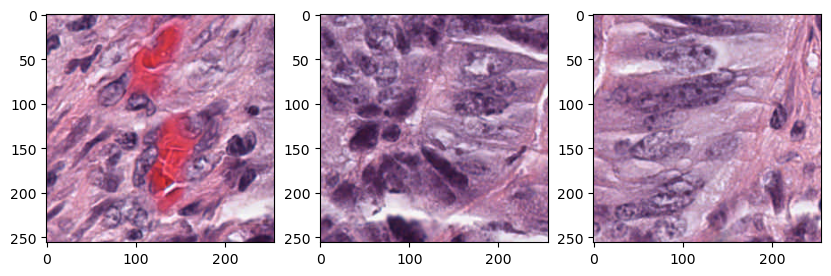

In [77]:
imgs = np.array(d["image"])
imgs = np.moveaxis(imgs, 1, -1)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(imgs[0].astype(np.uint8))
ax[1].imshow(imgs[1].astype(np.uint8))
ax[2].imshow(imgs[2].astype(np.uint8))

So, we have shown a few ways that you can load and process batches of images, but there is plenty more to play around with if you have specific needs that are not met by what we have seen already. We will now move on to doing some inference using HoVerNet

HoVerNet can produces 3 branches of output which contain a nucleus probability map, a class probability map and a 2 channel Horizontal and Vertical distance from the centroid map. These outputs require some post-processing to convert the raw predictions into cleanly segmented and typed nuclei. 

![image](images/Post_Processing_Workflow.png)

Monai contains all of the necessary capabilities to be able to do this post-processing and it is accmplished with - guess what - *Transforms*!

In [81]:
log_dir = "outputs"

torch.cuda.set_device(0)
device = torch.device("cuda")

# Preprocessing transforms
pre_transforms = Compose(
    [
        CastToTyped(keys=["image"], dtype=torch.float32),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

# Dataset of patches
dataset = PatchWSIDataset(
    data_list,
    patch_size=256,
    patch_level=0,
    include_label=False,
    transform=pre_transforms,
    reader="cuCIM",
    #additional_meta_keys=["mask_location"],
)
print("dataset created")

# Dataloader
data_loader = DataLoader(dataset, 
                        num_workers=2, 
                        batch_size=8, 
                        pin_memory=True,)
print("dataloader created")

dataset created
dataloader created
CPU times: user 0 ns, sys: 3.25 ms, total: 3.25 ms
Wall time: 3.08 ms


In [82]:
first_sample = first(data_loader)

print("image: ")
print("    shape", first_sample["image"].shape)
print("    type: ", type(first_sample["image"]))
print("    dtype: ", first_sample["image"].dtype)

print(f"number of batches: {len(data_loader)}")

image: 
    shape torch.Size([8, 3, 256, 256])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
number of batches: 8


(2, 164)


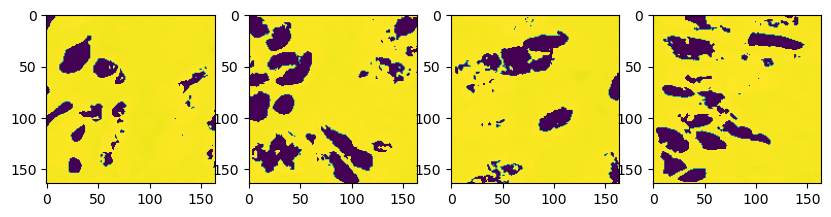

In [152]:
# Create model 
model = HoVerNet(
    mode="fast", 
    in_channels=3, 
    out_classes=5, 
    act=("relu", {"inplace": True}), 
    norm="batch", 
    dropout_prob=0.0,
)

device = torch.device("cuda:0")

#Load the pre-trained weights
model.load_state_dict(torch.load("data/fast.pt")['model'])
model = model.to(device)
model.eval()

inferer = SimpleInferer()

dataloader = DataLoader(dataset=dataset, batch_size=4, num_workers=8)
model.eval()
with torch.no_grad():
    for d in dataloader:
        pred = inferer(inputs=d["image"].to(device), network=model)
        imgs = np.array(pred["nucleus_prediction"][:4].cpu())
        break
        
print(imgs[0,:,:,0].shape)
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(imgs[0,1,:,:].astype(np.uint8))
ax[1].imshow(imgs[1,1,:,:].astype(np.uint8))
ax[2].imshow(imgs[2,1,:,:].astype(np.uint8))
ax[3].imshow(imgs[3,1,:,:].astype(np.uint8))


So, we now have some inference results from HoVerNet, but this is without any postprocessing. Preprocessing is already invoked when the data is loaded, to normalize the intensity. Let's now define some post-processing to clean up the inference predictions. 


## Setup a post-processing pipeline to convert the predictions into the desired outputs
Here we use several transforms to turn pixel-level predictions into maps, contours and images that can be saved to disk:
1. `GenerateWatershedMaskd` Creates a binary mask within which to compute watershed
2. `GenerateInstanceBorderd` Generate an instance border using a horizontal and vertical (hover) distance map
3. `GenerateDistanceMapd` Within a segmentation region, computes the distance from the centre for horizontal and vertical axes
4. `GenerateWatershedMarkersd` Generate markers to be used in `Watershed` algorithm
6. `Watershedd` Uses the watershed algorithm to link pixels to specific object instances

We could implement these directly or, for an easier life, we can just use the predefined HoVerNet PostProcessing pipeline

In [169]:
 # Postprocessing transforms
post_transforms = Compose(
    [
        HoVerNetInstanceMapPostProcessingd(sobel_kernel_size=21, marker_threshold=0.4, marker_radius=2),
        HoVerNetNuclearTypePostProcessingd(),
    ]
)

In [188]:
dataloader = DataLoader(dataset=dataset, batch_size=4, num_workers=8)
model.eval()
out=[]

with torch.no_grad():
    for d in dataloader:
        pred = inferer(inputs=d["image"].to(device), network=model)

        nu = np.array(pred["nucleus_prediction"].cpu())
        hv = np.array(pred["horizontal_vertical"].cpu())
        tp = np.array(pred["type_prediction"].cpu())
        
        for i in range(len(nu)):
            inputs =  {"nucleus_prediction": nu[i], "horizontal_vertical": hv[i], "type_prediction": tp[i]}
            out.append(post_transforms(inputs))  
                       
        break
        
# Plot out the cleaned up instance map
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(out[0]["instance_map"].squeeze())
ax[1].imshow(out[1]["instance_map"].squeeze())
ax[2].imshow(out[2]["instance_map"].squeeze())
ax[3].imshow(out[3]["instance_map"].squeeze())

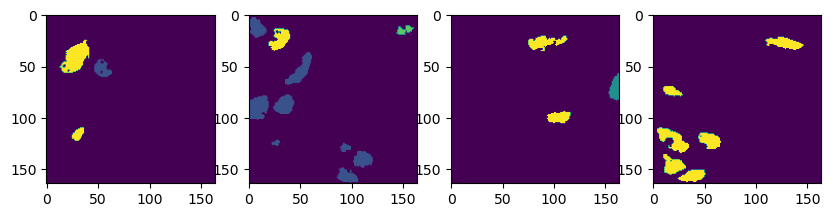

In [193]:
# Plot out the type map (nucleus sub-types)
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(out[0]["type_map"].squeeze())
ax[1].imshow(out[1]["type_map"].squeeze())
ax[2].imshow(out[2]["type_map"].squeeze())
ax[3].imshow(out[3]["type_map"].squeeze())

There are other abstractions that make using HoverNet even easier, such as using Ignite-based Evaluators, which include some nice features, 

In [191]:
def myfunc(engine, engine_state_batch):
    print("Iteration Update Event Fired!")
    
with tqdm(total=len(data_loader)) as pbar:

    # Class used for event handling
    class TestEvalIterEvents:
        def attach(self, engine):
            engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self._forward_completed)

        def _forward_completed(self, engine):
            pbar.update(engine.state.iteration)

    # Define some Handlers
    inference_handlers = [
        TestEvalIterEvents(),
    ]

    model = model.to(device)

    # Use an Ignite-based Evaluator
    inference = SupervisedEvaluator(
        device=device,
        val_data_loader=data_loader,
        network=model,
        iteration_update=myfunc,
        val_handlers=inference_handlers,
        amp=True,
    )
    
    # This event can be used to stop iteration during training or evaluation
    EarlyStopHandler(
        patience=20, score_function=lambda x: 1.0, epoch_level=False, trainer=inference
    ).attach(inference)

    inference.run()


  0%|          | 0/8 [00:00<?, ?it/s]

2023-02-17 19:31:06,745 - Engine run resuming from iteration 0, epoch 0 until 1 epochs
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
Iteration Update Event Fired!
2023-02-17 19:31:07,263 - Epoch[1] Complete. Time taken: 00:00:00.187
2023-02-17 19:31:07,266 - Engine run complete. Time taken: 00:00:00.520


We can take a visual look at regions of interest on the input image and the corresponding inference and post-processing result 

In [ ]:
from cucim import CuImage
from matplotlib import pyplot as plt
import zarr
import random
import numpy as np

level=1
row = 21950
col = 53350

row = (row // 164) * 164
col = (col // 164) * 164

h = 2 * 164
w = 1 * 164

if h is None:
    h = w

wsi = CuImage("tcga1.svs")
sizes=wsi.metadata["cucim"]["resolutions"]

ratio_w = sizes["level_dimensions"][0][0] // sizes["level_dimensions"][level][0]
ratio_h = sizes["level_dimensions"][0][1] // sizes["level_dimensions"][level][1]
print(1)

img = wsi.read_region(location=(col+46,row+46), size=(w//ratio_w,h//ratio_h), level=level)
print(2)

y = row % 164
x = col % 164

seg = zarr.load('/datasets/wsi/outputs/tcga1.svs.zarr')
print(3)
#seg2 = np.zeros((h,w),dtype=int)
#seg3 = np.zeros((h,w),dtype=int)

seg2 = seg[row:row+h,col:col+w,0]

print(x,y)
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(img)
ax[1].imshow(seg2)
#ax[2].imshow(seg3)


Now we can plot out the centroids for a region of interest

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

row = 21950
col = 53350

row = (row // 164) * 164
col = (col // 164) * 164

h = 10 * 164
w = 10 * 164

if h is None:
    h = w

points = seg[row:row+h,col:col+w,1]

lst = []
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        if points[i,j] > 0:
            lst.append({"x" : j, "y":points.shape[0]- i, "type": points[i,j]})
            
centres = np.zeros((len(lst),3),dtype=int)
label = [""] * len(lst)
for i, item in enumerate(lst):
    centres[i] = [item["x"], item["y"], item["type"]-1]  
    label[i] = str(item["x"]) + "," + str(item["y"])
            
plt.style.use('_mpl-gallery')

# plot
cmap = ListedColormap(["blue", "gold", "lawngreen", "red"])
fig, ax = plt.subplots(figsize = (5,5))

ax.scatter(centres[:,0], centres[:,1], c=centres[:,2], cmap=cmap)

ax.set(xlim=(0, points.shape[0]), xticks=np.arange(0, points.shape[0],164),
       ylim=(0, points.shape[0]), yticks=np.arange(0, points.shape[0], 164))

plt.show()
